# Final Notebook 001 - Data Acquisition and Descriptive Statistics

## Import

In [1]:
import sentisignal
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np 
import pylab as P 
import ast
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import scipy.stats as s
import statsmodels.api as sm
import pprint
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from datetime import datetime
from yahoo_finance import Share
from pandas_datareader import data, wb
from statsmodels.graphics.api import qqplot
from operator import itemgetter
from decimal import *

# plt.style.use('ggplot')
# sns.set_style("darkgrid")
# sns.set_context("notebook")

## Configuration

In [3]:
data_primary_path = '../../data/csv/stocktwits_twitter_withretweets_daily.csv'
data_symbology_path = '../../data/csv/symbology.csv'
data_pickles_path = '../../data/pickles/'
data_nasdaq_company_list_path = '../../data/nasdaq/companylist.csv'
start_date = '2012-01-01'
end_date = '2016-01-01'

## NASDAQ Data

In [4]:
data_symbology = pd.read_csv(data_symbology_path)

### Use NASDAQ data to get top 100 companies by MarketCap

In [5]:
data_nasdaq_company_list = pd.read_csv(data_nasdaq_company_list_path)
data_nasdaq_top_100_mkt_cap = data_nasdaq_company_list.head(100)
data_nasdaq_top_100_mkt_cap_symbols = data_nasdaq_top_100_mkt_cap['Symbol'].unique()

### Calculate breakdown per sector (using PsychSignal symbology)

(-1.0128662320463357, 1.0, -1.0193658825849057, 1.0141629122482432)

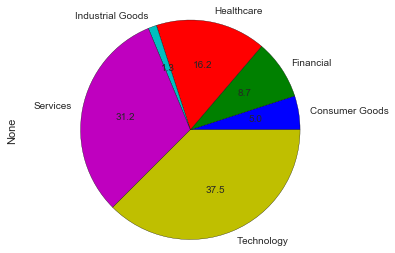

In [6]:
data_nasdaq_top_100_mkt_cap_symbology = pd.merge(data_nasdaq_top_100_mkt_cap, data_symbology, left_on='Symbol', right_on='symbol', how = "left")
data_nasdaq_top_100_mkt_cap_symbology_sector_size = data_nasdaq_top_100_mkt_cap_symbology.groupby(['sector']).size()
data_nasdaq_top_100_mkt_cap_symbology_sector_size.plot(kind='pie', autopct='%.1f')
plt.axis('equal')

### Calculate and graph yearly mean of average monthly messages

In [7]:
sum_avg_cols = [col for col in data_nasdaq_top_100_mkt_cap_symbology.columns if ('all_scanned_20' in col and 'avg_monthly' in col)]
data_nasdaq_top_100_mkt_cap_symbology['mean_avg_monthly'] = data_nasdaq_top_100_mkt_cap_symbology[sum_avg_cols].sum(axis=1)/len(sum_avg_cols)

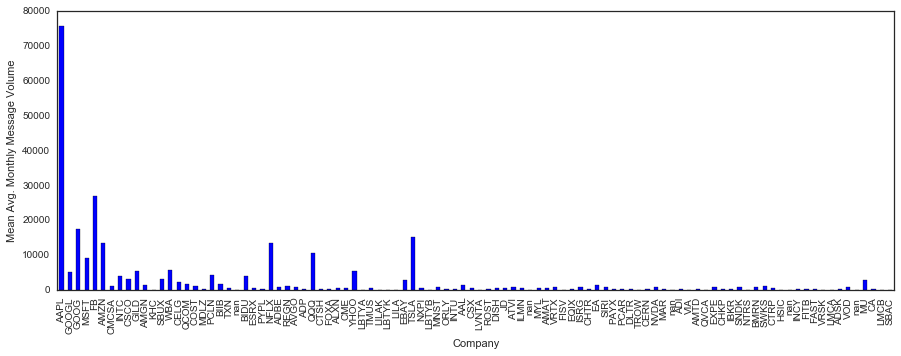

In [8]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
data_nasdaq_top_100_mkt_cap_symbology['mean_avg_monthly'].plot(kind='bar')
ax.set_xticklabels(data_nasdaq_top_100_mkt_cap_symbology['symbol'], rotation=90)
plt.ylabel('Mean Avg. Monthly Message Volume')
plt.xlabel('Company')
plt.show()

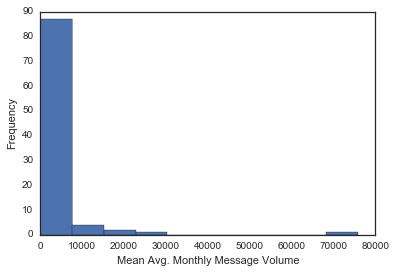

In [9]:
data_nasdaq_top_100_mkt_cap_symbology.hist(column=['mean_avg_monthly'], grid=False)
plt.ylabel('Frequency')
plt.xlabel('Mean Avg. Monthly Message Volume')
plt.title('')

### MarketCap and mean_avg_monthly regression

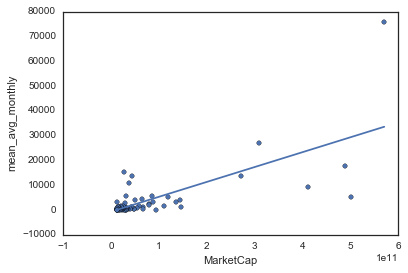

In [10]:
sentisignal.plot_scatter_regression(data_nasdaq_top_100_mkt_cap_symbology, 'MarketCap', 'mean_avg_monthly')

## Subsample sentiment data (Daily Stocktwits and Twitter with retweets)

In [32]:
data_nasdaq_top_100_sentiment = sentisignal.subsample_data(data_primary_path, data_symbology_path, data_pickles_path, start_date, end_date, 'SYMBOL', data_nasdaq_top_100_mkt_cap_symbols, False)

Loaded from pre-created pickle


## Scrape finance data (Yahoo! Finance)

In [1]:
data_nasdaq_top_100_finance = sentisignal.get_data_finance('google', data_nasdaq_top_100_mkt_cap_symbols, start_date, end_date, data_pickles_path, False, 'NaN')

NameError: name 'sentisignal' is not defined

### Preprocess and merge

In [13]:
# preprocess creating additional statistics 
[data_nasdaq_top_100_sentiment_preprocessed, data_nasdaq_top_100_finance_preprocessed] = sentisignal.preprocess_per_symbol(data_nasdaq_top_100_sentiment, data_nasdaq_top_100_finance)

In [14]:
data_nasdaq_top_100_preprocessed_merge = sentisignal.merge_sentiment_finance(data_nasdaq_top_100_sentiment_preprocessed, data_nasdaq_top_100_finance_preprocessed, True, True, True)

### Describe

In [15]:
data_nasdaq_top_100_preprocessed_merge.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BULLISH_INTENSITY,79792,1.455372,0.876189,0.000000e+00,0.890000,1.760000,2.060000,3.890000e+00
BEARISH_INTENSITY,79792,1.091732,1.014030,0.000000e+00,0.000000,1.310000,1.950000,4.000000e+00
BULL_MINUS_BEAR,79792,0.363640,1.181330,-4.000000e+00,-0.210000,0.030000,1.200000,3.630000e+00
BULL_SCORED_MESSAGES,79792,31.232241,154.694749,0.000000e+00,1.000000,3.000000,14.000000,1.455400e+04
BEAR_SCORED_MESSAGES,79792,16.385202,77.514645,0.000000e+00,0.000000,1.000000,5.000000,3.317000e+03
BULL_BEAR_MSG_RATIO,79792,1.768368,4.738642,0.000000e+00,0.000000,0.500000,2.170000,5.940000e+02
TOTAL_SCANNED_MESSAGES,79792,166.491014,628.957133,1.000000e+00,7.000000,21.000000,77.000000,3.076600e+04
LOG_BULL_RETURN,79792,0.160146,0.944510,-4.907230e+00,-0.405465,0.000000,0.693147,5.986452e+00
LOG_BEAR_RETURN,79792,0.137470,0.871547,-4.197202e+00,-0.287682,0.000000,0.693147,5.120983e+00
LOG_BULLISHNESS,79792,0.602013,0.867663,-3.828641e+00,0.000000,0.693147,1.098612,6.104933e+00


### Correlation matrix

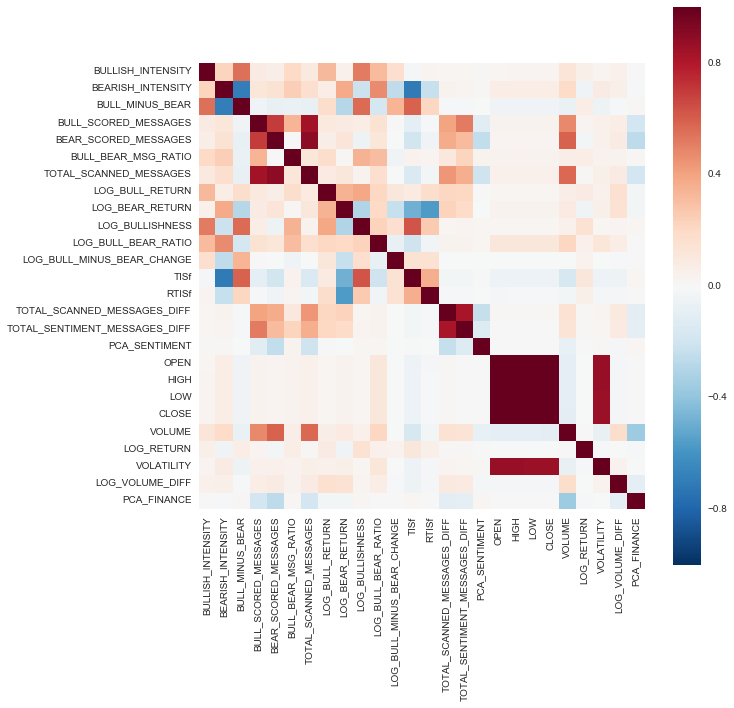

In [16]:
sentisignal.plot_corr(data_nasdaq_top_100_preprocessed_merge)

### Clustermap

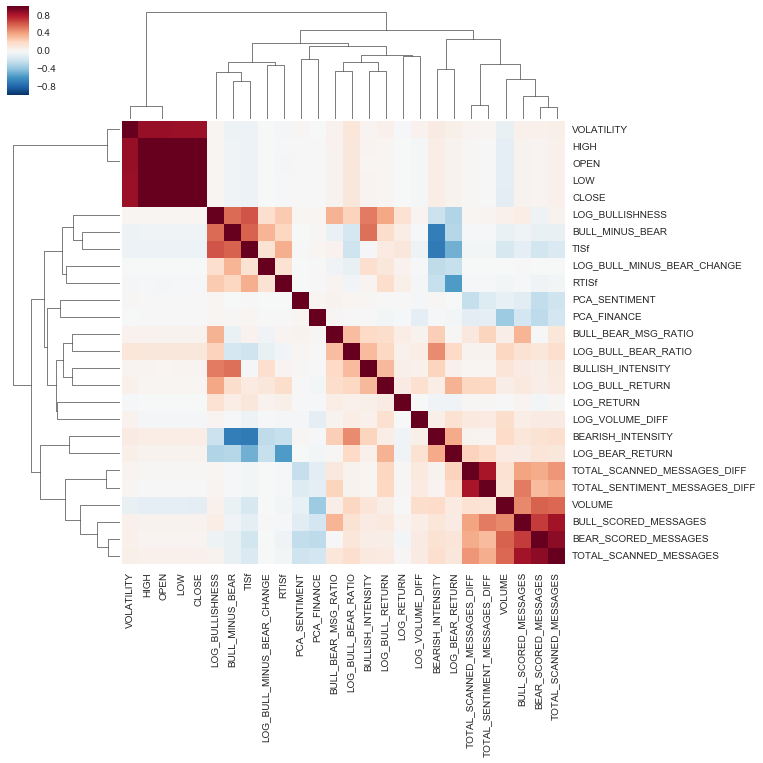

In [17]:
sentisignal.plot_clustermap(data_nasdaq_top_100_preprocessed_merge)


### PDF

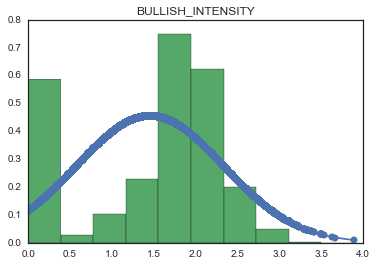

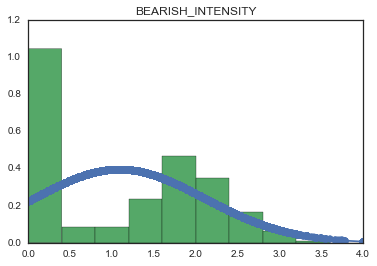

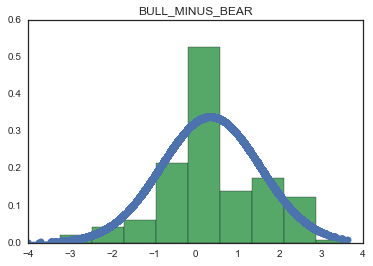

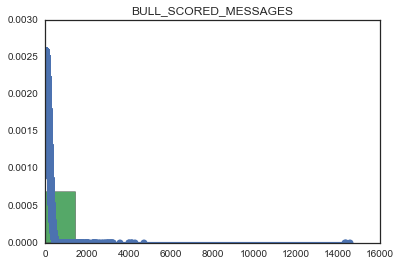

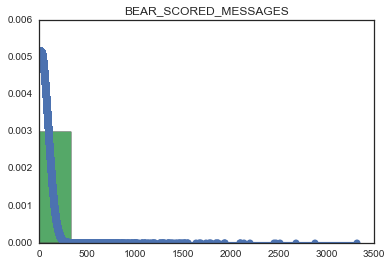

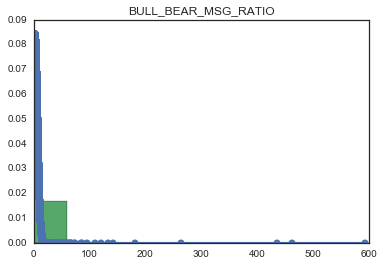

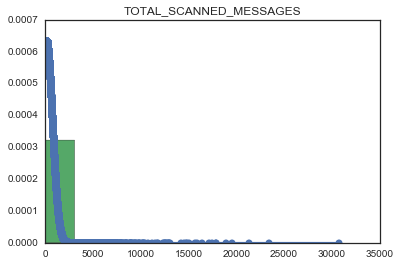

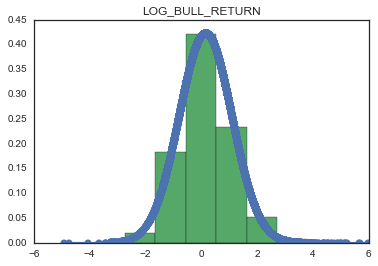

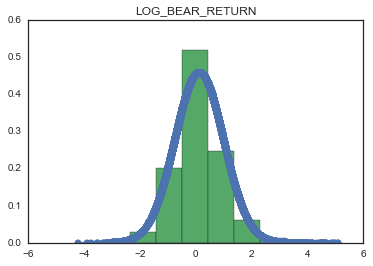

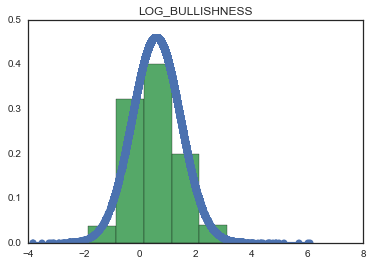

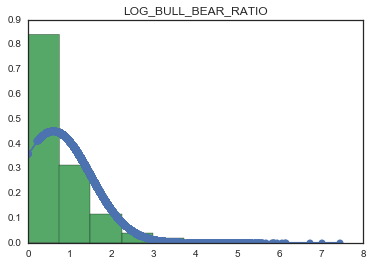

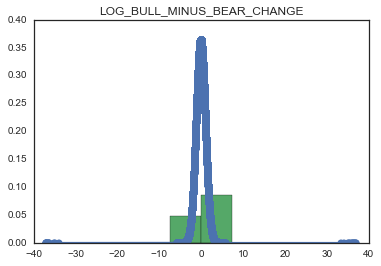

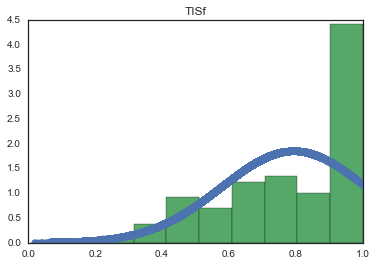

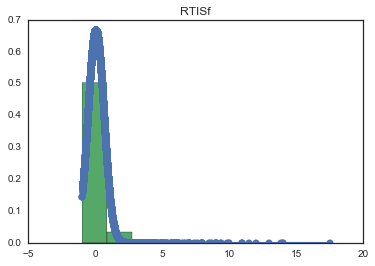

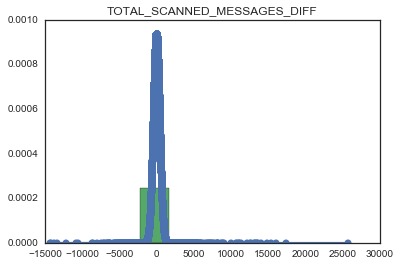

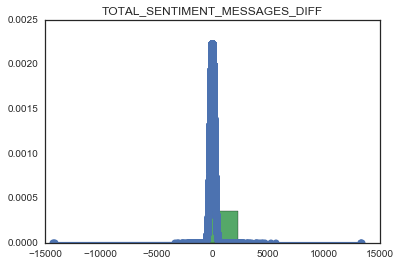

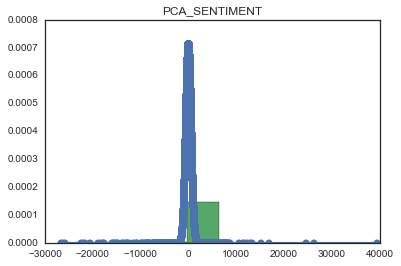

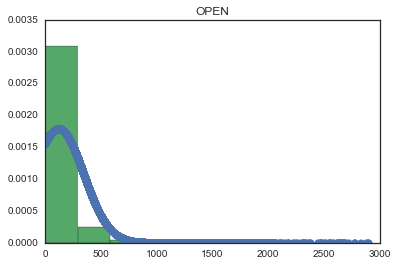

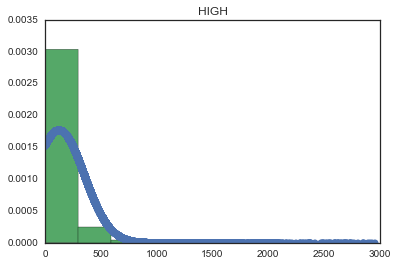

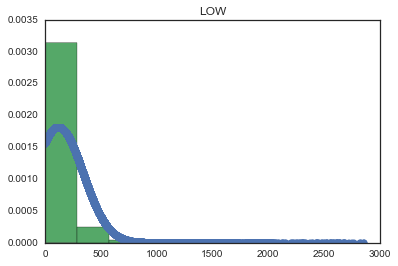

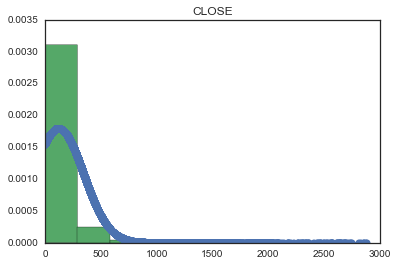

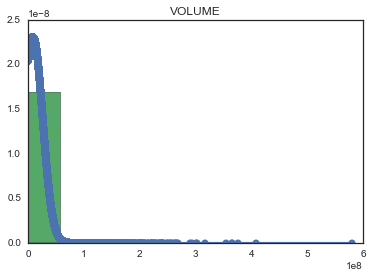

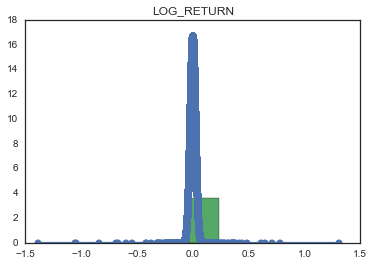

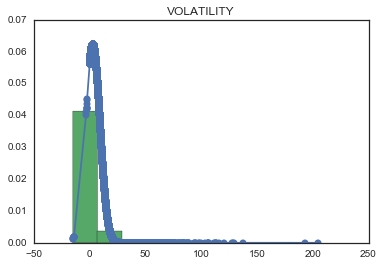

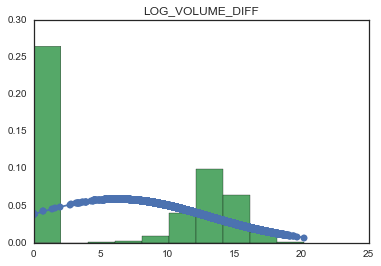

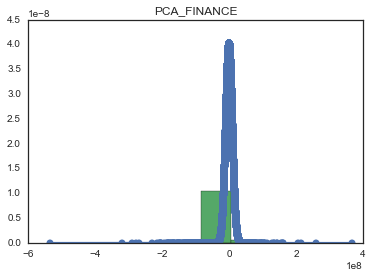

In [18]:
sentisignal.check_pdf(data_nasdaq_top_100_preprocessed_merge)

### ACF

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


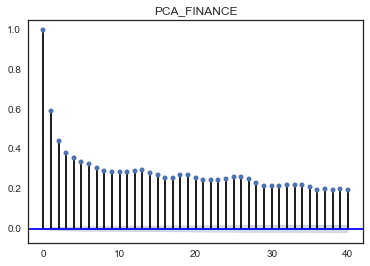

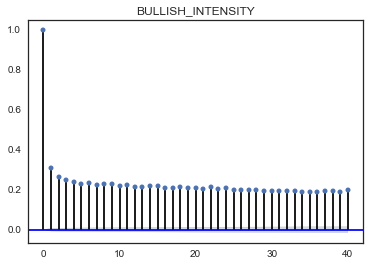

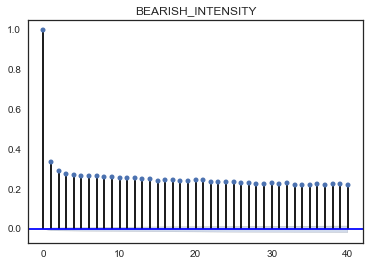

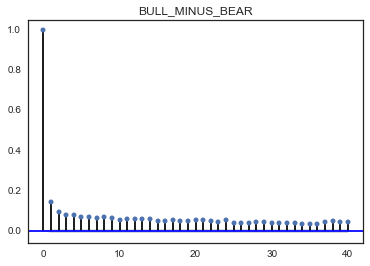

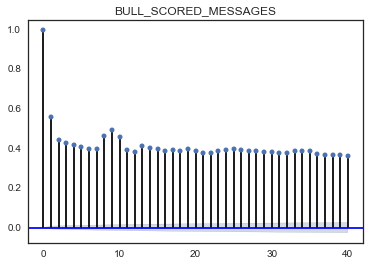

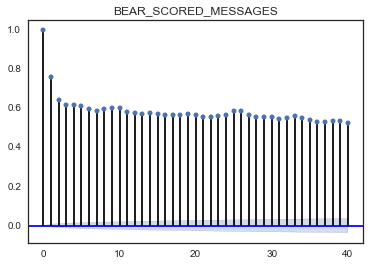

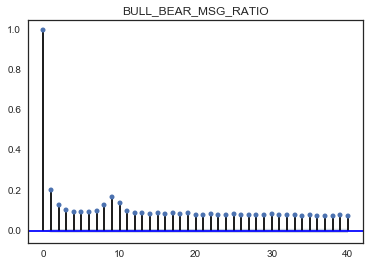

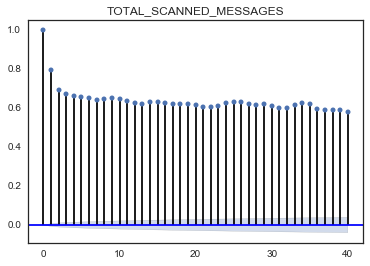

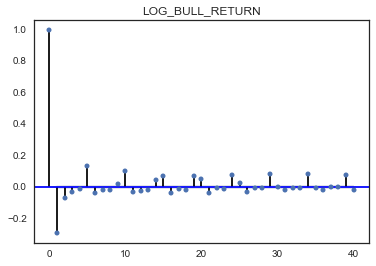

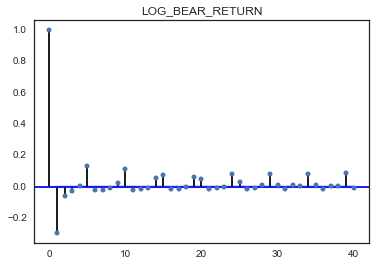

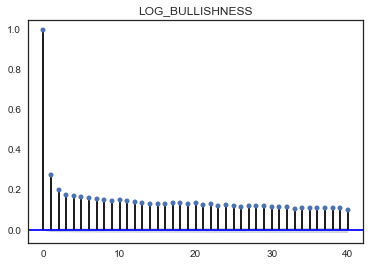

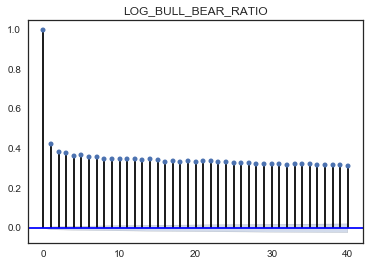

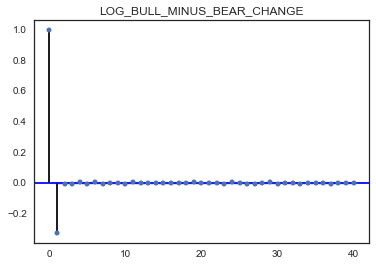

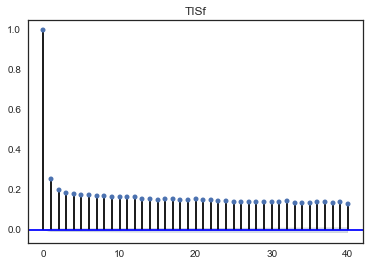

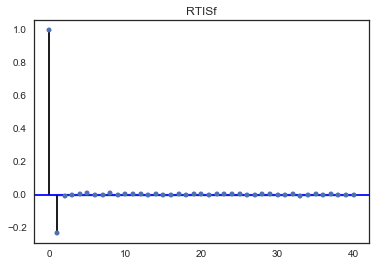

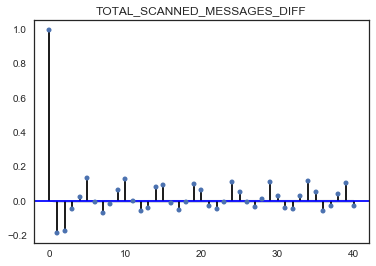

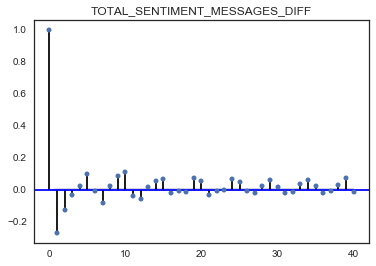

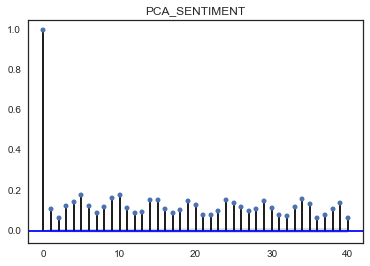

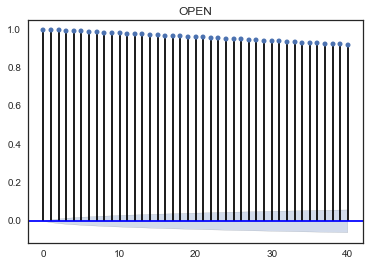

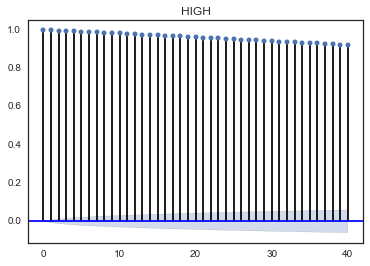

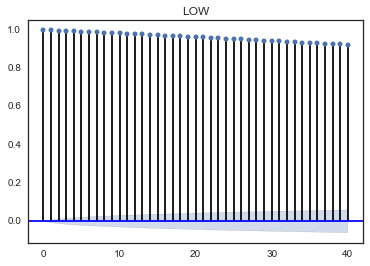

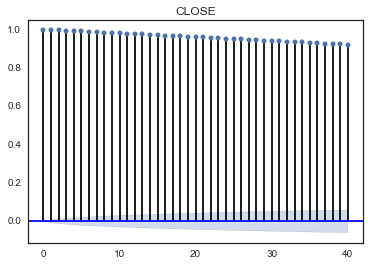

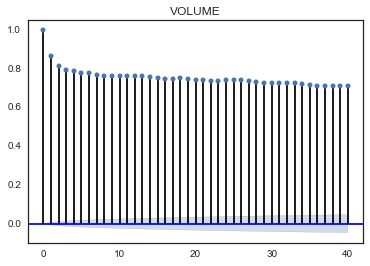

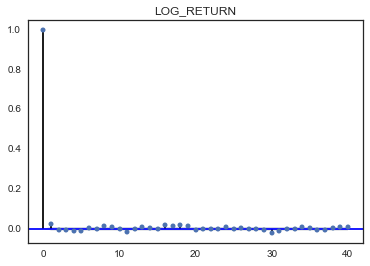

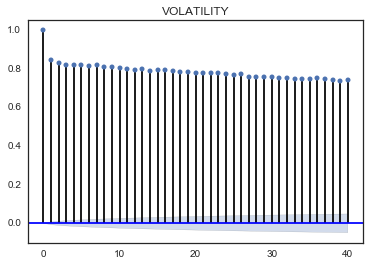

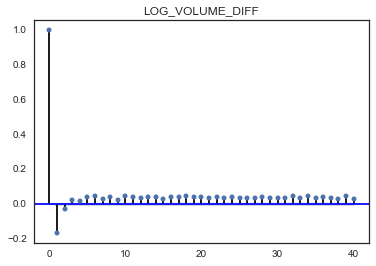

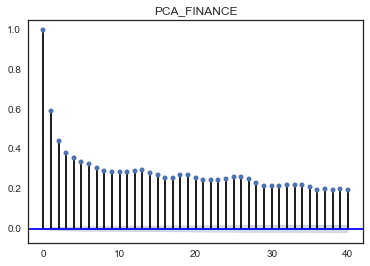

In [19]:
sentisignal.check_acf(data_nasdaq_top_100_preprocessed_merge)

### Regression between PCA (Sentiment) and PCA (Finance)

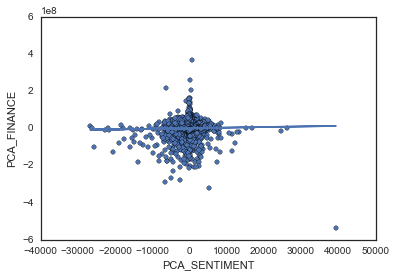

In [20]:
sentisignal.plot_scatter_regression(data_nasdaq_top_100_preprocessed_merge, 'PCA_SENTIMENT', 'PCA_FINANCE')

### Save results to intermediate pickle

In [21]:
data_nasdaq_top_100_preprocessed_merge.to_pickle(data_pickles_path+'intermediate/'+'data_nasdaq_top_100_preprocessed_merge_'+start_date+'_'+end_date)

## Apply rolling window and repeat analysis

In [22]:
data_nasdaq_top_100_preprocessed_merge_window_30 = sentisignal.split_apply_combine(data_nasdaq_top_100_preprocessed_merge, 'SYMBOL', sentisignal.apply_rolling_window, 30)

### Describe

In [23]:
data_nasdaq_top_100_preprocessed_merge_window_30.describe()

,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,BULL_BEAR_MSG_RATIO,TOTAL_SCANNED_MESSAGES,LOG_BULL_RETURN,LOG_BEAR_RETURN,LOG_BULLISHNESS,...,PCA_SENTIMENT,OPEN,HIGH,LOW,CLOSE,VOLUME,LOG_RETURN,VOLATILITY,LOG_VOLUME_DIFF,PCA_FINANCE
count,79791.000000,79791.000000,79791.000000,79791.000000,79791.000000,79791.000000,79791.000000,79791.000000,79791.000000,79791.000000,...,79791.000000,79791.000000,79791.000000,79791.000000,79791.000000,7.979100e+04,79791.000000,79791.000000,79791.000000,7.979100e+04
mean,1.446765,1.084487,0.362278,31.170104,16.431494,1.747979,165.939571,0.161855,0.138732,0.596073,...,1.845878,123.132210,124.255185,121.375983,123.212436,8.676875e+06,0.000718,2.882096,6.216627,-5.941038e+04
std,0.450558,0.550709,0.383397,104.854774,62.651524,1.770657,527.949579,0.138206,0.146286,0.380838,...,260.909932,224.207437,226.777041,221.253779,223.989230,1.562092e+07,0.005064,5.884621,1.590789,6.154578e+06
min,0.000000,0.000000,-2.490000,0.000000,0.000000,0.000000,1.000000,-1.386294,-1.386294,-1.945910,...,-4023.308235,0.000000,0.000000,0.000000,0.419000,0.000000e+00,-0.373640,-9.182857,0.000000,-2.438011e+08
25%,1.135667,0.624000,0.073667,1.833333,0.680909,0.472333,10.933333,0.059725,0.032694,0.317015,...,-8.952336,32.657000,32.887167,32.232167,32.691333,1.280135e+06,-0.001090,0.660667,5.723300,-5.123781e+05
50%,1.590667,1.051000,0.330333,4.600000,1.600000,1.417333,26.500000,0.146068,0.099184,0.560569,...,-0.122964,56.279667,56.655000,55.404333,56.313333,2.961703e+06,0.000797,1.094000,6.397156,8.066682e+03
75%,1.799333,1.624667,0.619333,15.333333,5.700000,2.501667,84.766667,0.251218,0.216398,0.839895,...,11.731907,103.392500,103.968333,101.396667,103.482833,8.570558e+06,0.002644,2.387000,7.067252,5.796922e+05
max,3.040000,2.780000,3.040000,2820.000000,1607.666667,34.628333,17885.000000,3.135494,2.772589,3.332205,...,22179.150922,2693.583333,2729.383000,2653.365667,2687.483333,2.902939e+08,0.128524,83.653333,15.997215,4.947310e+07


### Correlation matrix

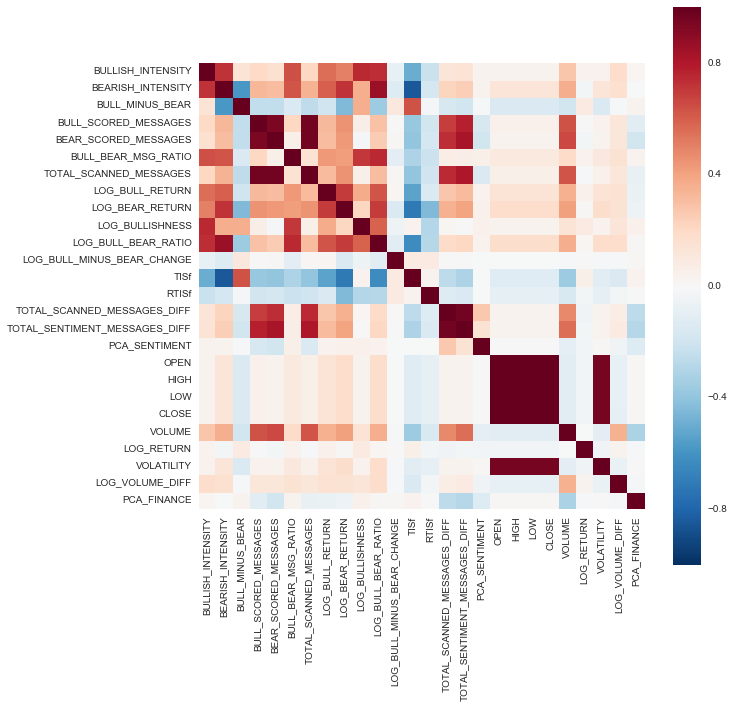

In [24]:
sentisignal.plot_corr(data_nasdaq_top_100_preprocessed_merge_window_30)

### Clustermap

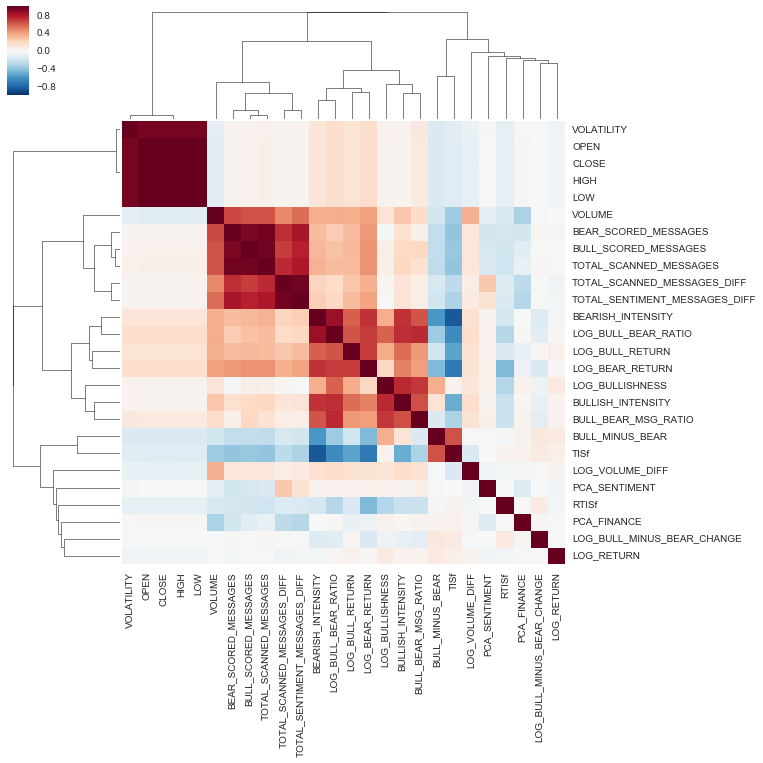

In [25]:
sentisignal.plot_clustermap(data_nasdaq_top_100_preprocessed_merge_window_30)

### PDF

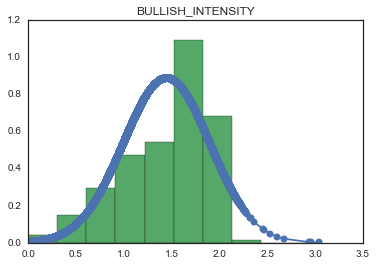

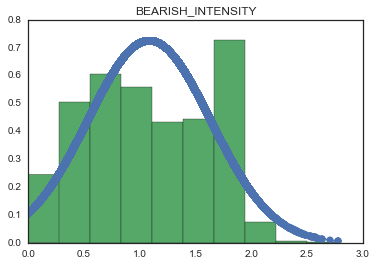

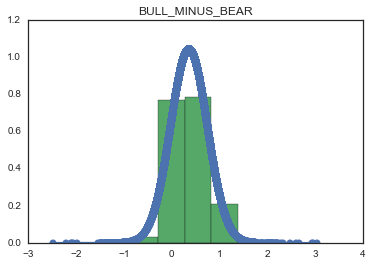

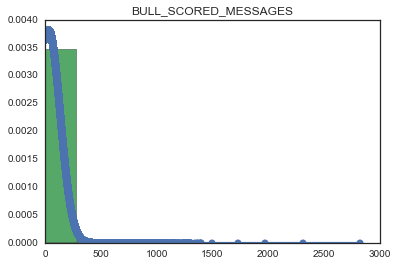

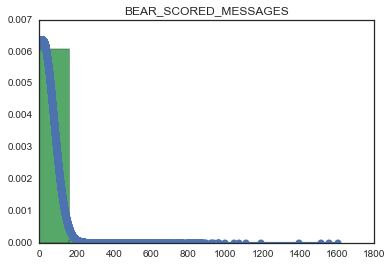

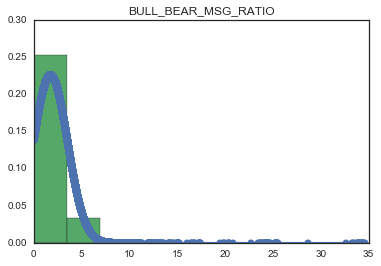

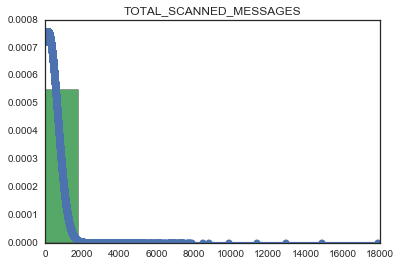

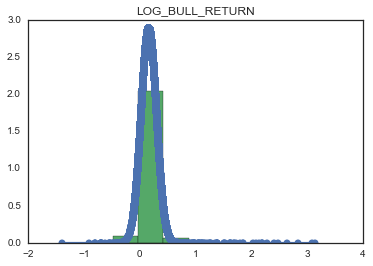

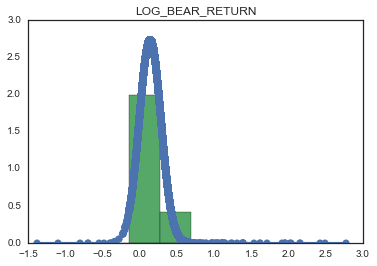

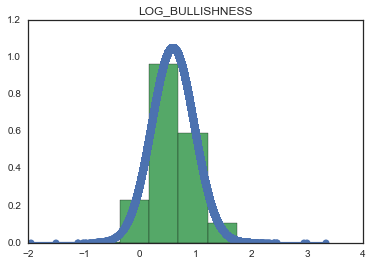

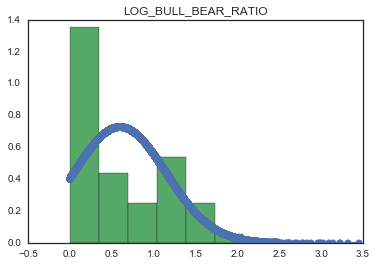

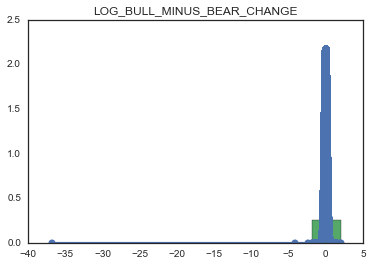

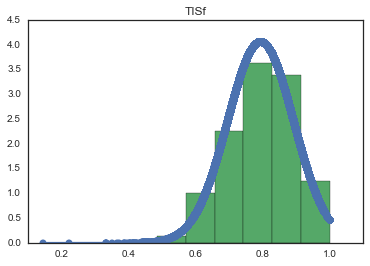

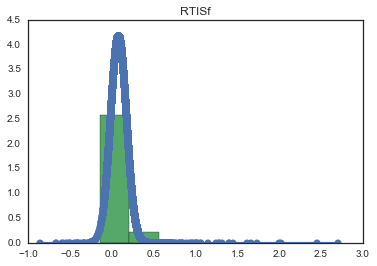

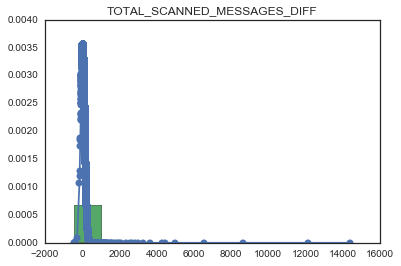

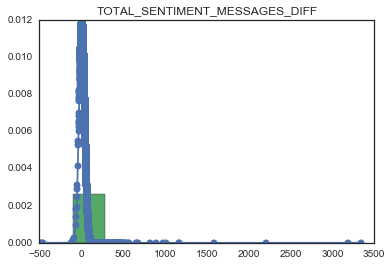

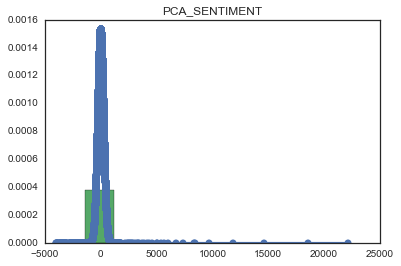

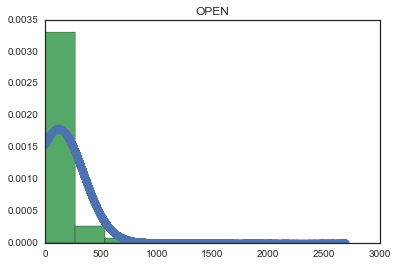

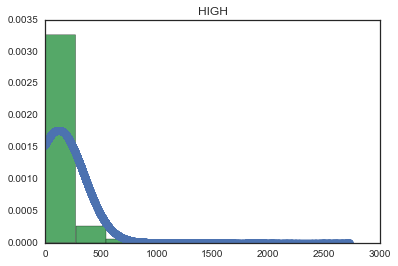

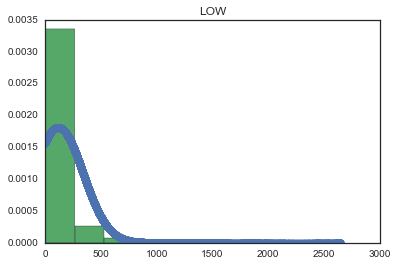

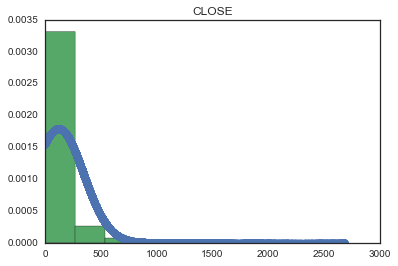

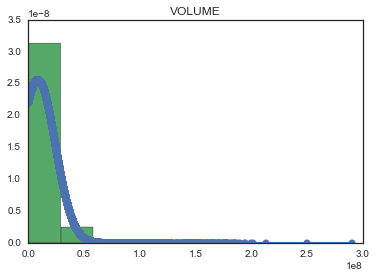

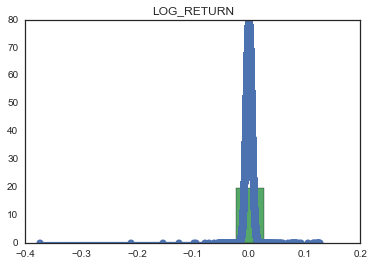

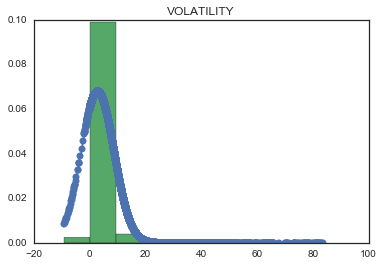

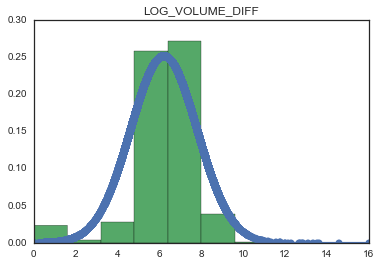

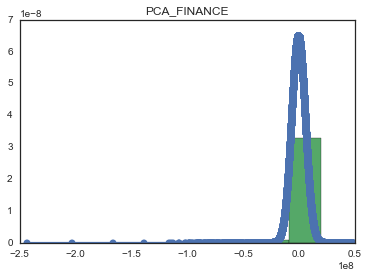

In [26]:
sentisignal.check_pdf(data_nasdaq_top_100_preprocessed_merge_window_30)

### ACF

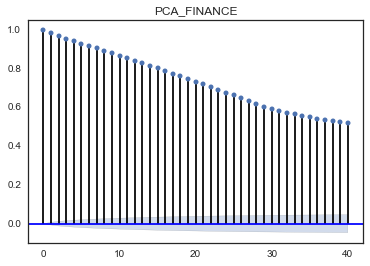

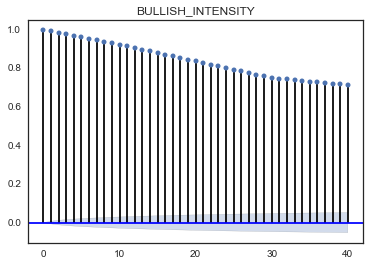

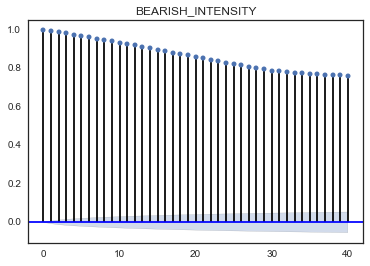

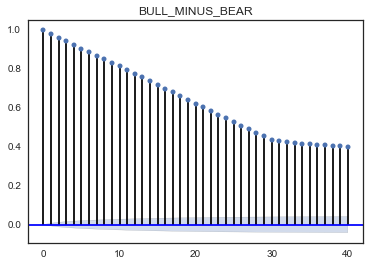

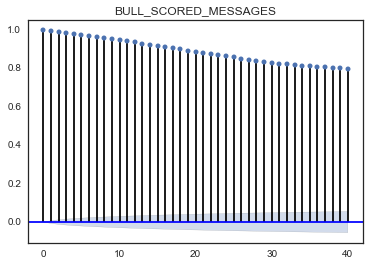

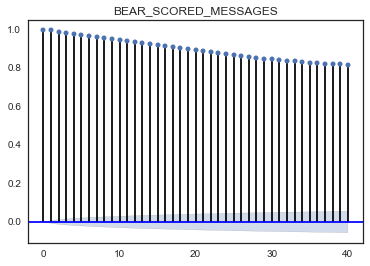

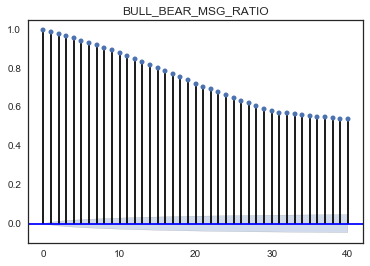

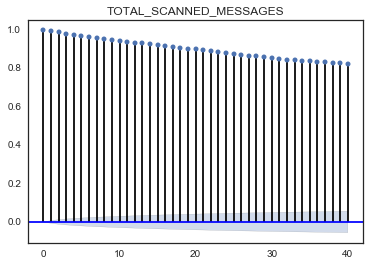

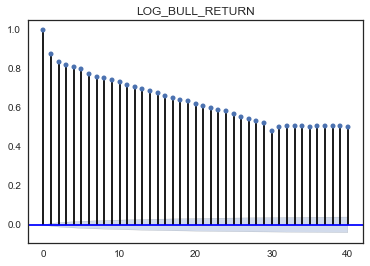

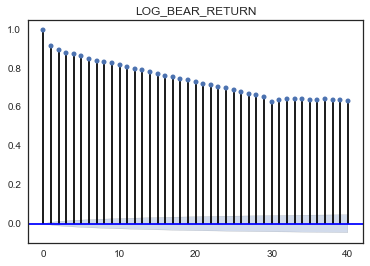

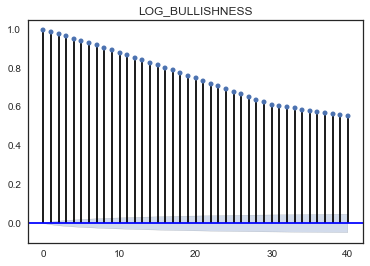

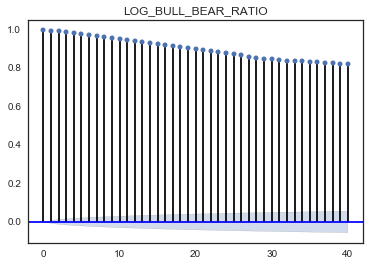

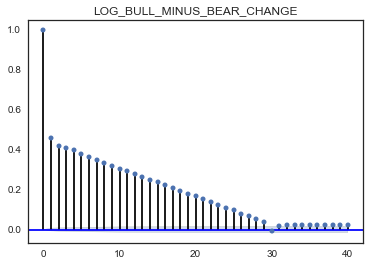

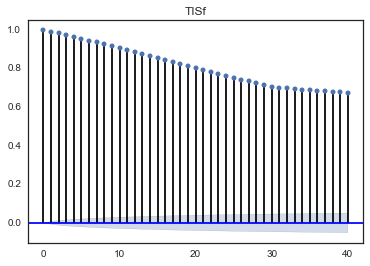

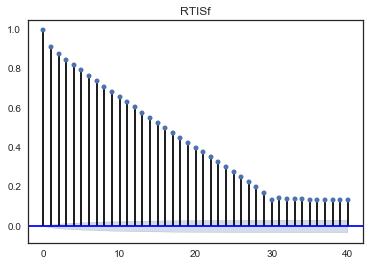

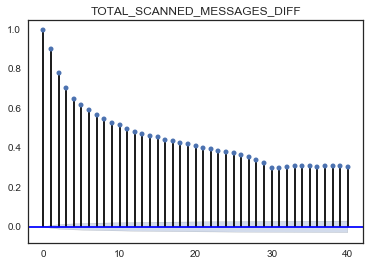

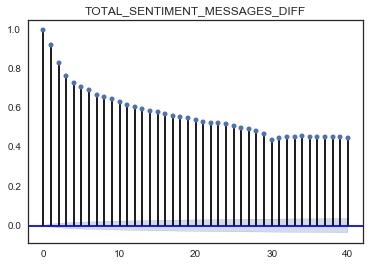

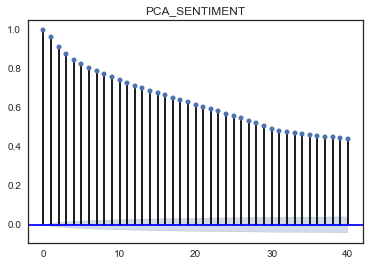

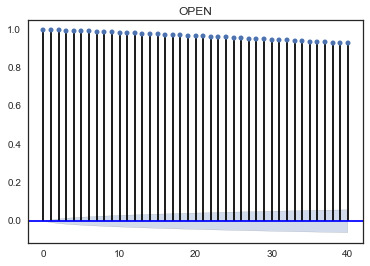

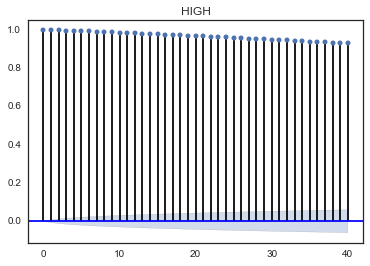

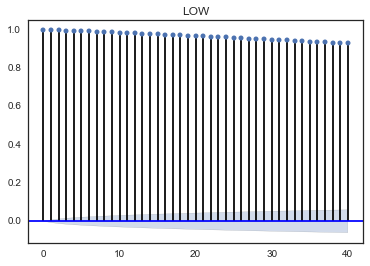

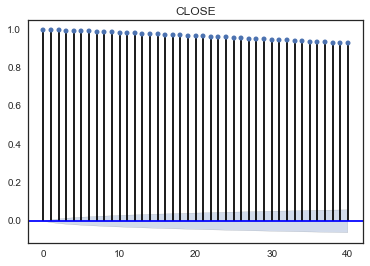

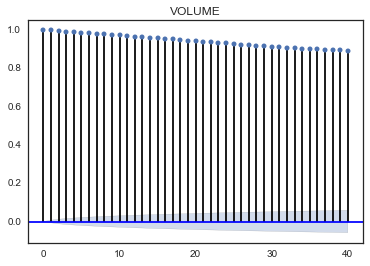

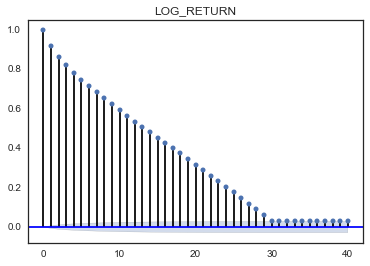

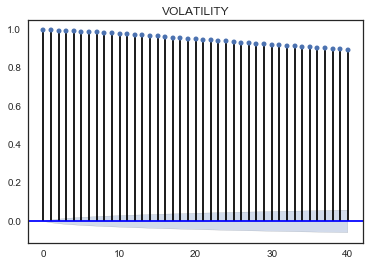

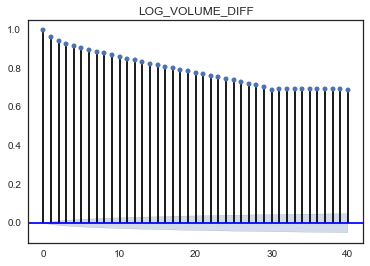

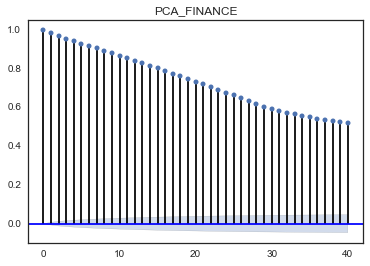

In [27]:
sentisignal.check_acf(data_nasdaq_top_100_preprocessed_merge_window_30)

### Regression plot PCA (Sentiment) and PCA (Finance)

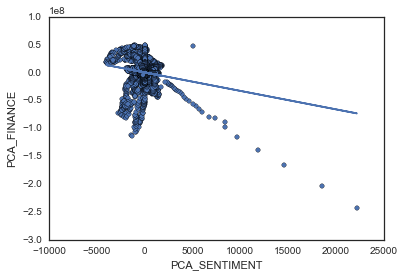

In [28]:
sentisignal.plot_scatter_regression(data_nasdaq_top_100_preprocessed_merge_window_30, 'PCA_SENTIMENT', 'PCA_FINANCE')

### Save results to intermediate pickle

In [31]:
data_nasdaq_top_100_preprocessed_merge_window_30.to_pickle(data_pickles_path+'intermediate/'+'data_nasdaq_top_100_preprocessed_merge_'+start_date+'_'+end_date+'_window_'+str(30))